Reference: https://ycy-tw.github.io/2020/02/11/%E5%88%A9%E7%94%A8ARIMA%E9%80%B2%E8%A1%8C%E8%82%A1%E5%83%B9%E9%A0%90%E6%B8%AC(Forecasting%20Stock%20Price%20with%20ARIMA)/

In [ ]:
import numpy as np
import pandas as pd
from tabulate import tabulate
from pandas.plotting import autocorrelation_plot
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")

In [ ]:
route = r'2330_price.csv'
data = pd.read_csv(route, index_col=0)
data.head()

,Close
Date,
2019/1/2,219.5
2019/1/3,215.5
2019/1/4,208.0
2019/1/7,213.0
2019/1/8,211.0


## Autocorrelation

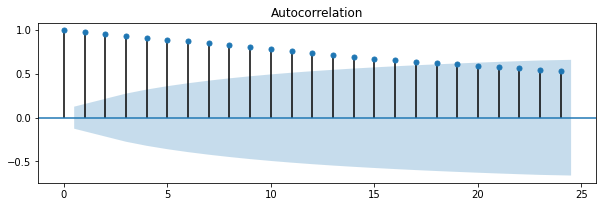

In [ ]:
fig = plt.figure(figsize=(10,10))
ax1 = fig.add_subplot(311)
fig = plot_acf(data, ax=ax1, title="Autocorrelation")

In [ ]:
result = adfuller(data['Close'])
print('p-value: {}'.format(round(result[1],4)))

p-value: 0.9562


## Differencing

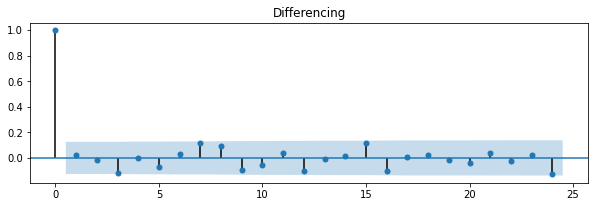

In [ ]:
fig = plt.figure(figsize=(10,10))
ax2 = fig.add_subplot(312)
fig = plot_acf(data.diff().dropna(), ax=ax2, title="Differencing")

In [ ]:
hiresult = adfuller(data['Close'].diff().dropna())
print('p-value: %f' % result[1])

p-value: 0.956203


## Choose p, q by AIC

In [ ]:
Order = []
for p in range(1,6):
    for q in range(1,3):
        try:
            model = ARIMA(data, order=(p, 1, q))
            results = model.fit(disp=0)
            Order.append(round(pd.read_html(results.summary().as_html(), header=0, index_col=0)[0].iloc[2,2],2))
        except:
            Order.append('NA')
            print('No Result')

b = [Order[i:i+2] for i in range(0,len(Order),2)]
Order_df = pd.DataFrame(b,index=range(1,6),columns=range(1,3))
Order_df.index.name = "p \\ q "
print(tabulate(Order_df, headers='keys', tablefmt='fancy_grid',numalign="center"))


No Result
No Result
╒══════════╤═════════╤═════════╕
│  p \ q   │    1    │ 2       │
╞══════════╪═════════╪═════════╡
│    1     │ 1307.96 │ NA      │
├──────────┼─────────┼─────────┤
│    2     │ 1310.15 │ NA      │
├──────────┼─────────┼─────────┤
│    3     │ 1309.33 │ 1310.82 │
├──────────┼─────────┼─────────┤
│    4     │ 1309.77 │ 1312.82 │
├──────────┼─────────┼─────────┤
│    5     │ 1311.96 │ 1305.39 │
╘══════════╧═════════╧═════════╛


In [ ]:
model = ARIMA(data, order=(5, 1, 2))
results = model.fit()
print(results.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  241
Model:                 ARIMA(5, 1, 2)   Log Likelihood                -643.694
Method:                       css-mle   S.D. of innovations              3.492
Date:                Thu, 04 Feb 2021   AIC                           1305.388
Time:                        06:46:38   BIC                           1336.751
Sample:                             1   HQIC                          1318.023
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.4751      0.202      2.352      0.019       0.079       0.871
ar.L1.D.Close    -0.2343      0.141     -1.658      0.099      -0.511       0.043
ar.L2.D.Close    -0.8532      0.094     

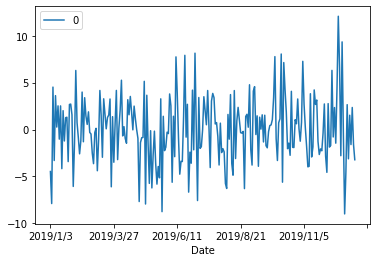

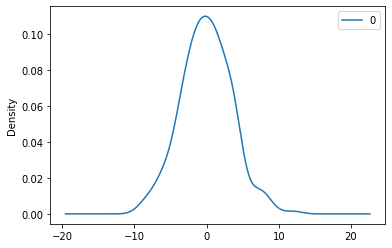

                0
count  241.000000
mean    -0.007211
std      3.506123
min     -8.994893
25%     -2.248216
50%     -0.031722
75%      2.364261
max     12.078977


In [ ]:
residuals = pd.DataFrame(results.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

## PACF & ACF

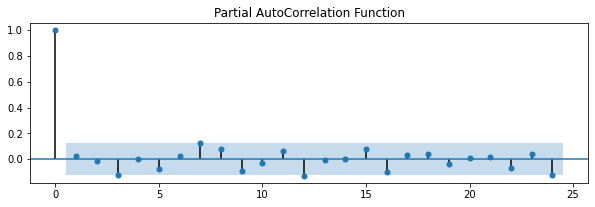

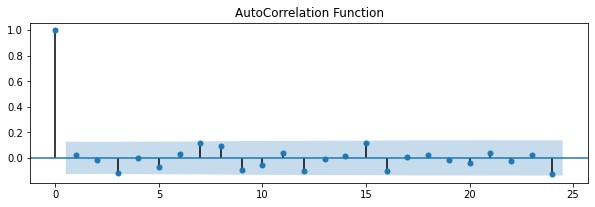

In [ ]:
fig = plt.figure(figsize=(10,10))
ax3 = fig.add_subplot(312)
fig = plot_pacf(data.diff().dropna(), ax=ax3, title="Partial AutoCorrelation Function")

fig = plt.figure(figsize=(10,10))
ax4 = fig.add_subplot(312)
fig = plot_acf(data.diff().dropna(), ax=ax4, title="AutoCorrelation Function")


In [ ]:
price = data.values
length = int(len(price) * 0.8)
train = list(price[0:length])
test =  price[length:len(price)]
date = data.index[length:len(price)]
predictions = []
low_bound = []
up_bound = []


for i in range(len(test)):
    model = ARIMA(train, order=(5, 1, 2))
    model_fit = model.fit(disp=0)
    pred = model_fit.forecast()[0]
    predictions.append(pred)
    real = test[i]
    train.append(real[0])   
    low_bound.append(model_fit.forecast()[2][0][0])
    up_bound.append(model_fit.forecast()[2][0][1])
    
    print(date[i] ,"|", 'Pred - '+str(round(pred[0],2)) ,"|", 'Real - '+str(real[0]))
    
MSE = mean_squared_error(test, predictions)
print('Mean Squared Error : '+str(round(MSE,4)))

2019/10/24 | Pred - 293.38 | Real - 293.0
2019/10/25 | Pred - 292.98 | Real - 293.5
2019/10/28 | Pred - 293.19 | Real - 294.5
2019/10/29 | Pred - 295.38 | Real - 298.5
2019/10/30 | Pred - 297.99 | Real - 299.5
2019/10/31 | Pred - 300.28 | Real - 298.5
2019/11/1 | Pred - 297.38 | Real - 299.0
2019/11/4 | Pred - 299.57 | Real - 307.0
2019/11/5 | Pred - 306.98 | Real - 310.5
2019/11/6 | Pred - 311.42 | Real - 311.0
2019/11/7 | Pred - 309.47 | Real - 309.0
2019/11/8 | Pred - 308.95 | Real - 305.5
2019/11/11 | Pred - 305.25 | Real - 301.0
2019/11/12 | Pred - 301.76 | Real - 305.0
2019/11/13 | Pred - 305.74 | Real - 304.0
2019/11/14 | Pred - 305.41 | Real - 303.5
2019/11/15 | Pred - 302.95 | Real - 307.0
2019/11/18 | Pred - 307.5 | Real - 311.0
2019/11/19 | Pred - 311.56 | Real - 315.0
2019/11/20 | Pred - 314.85 | Real - 313.5
2019/11/21 | Pred - 313.01 | Real - 311.0
2019/11/22 | Pred - 310.52 | Real - 309.0
2019/11/25 | Pred - 309.36 | Real - 307.0
2019/11/26 | Pred - 307.83 | Real - 307.0

In [ ]:

pred = pd.DataFrame(predictions, columns=['pred'])
#pred.head(3)
real = pd.DataFrame(test, columns=['real'])
#real.head(3)
low = pd.DataFrame(low_bound, columns=['lb'])
up = pd.DataFrame(up_bound, columns=['ub'])
#predictions = pd.DataFrame(predictions, columns=['pred'])

df = pd.merge(pred, real, left_index=True, right_index=True, how="inner")
df = pd.merge(df, low, left_index=True, right_index=True, how="inner")
df = pd.merge(df, up, left_index=True, right_index=True, how="inner")
df.head(3)

,pred,real,lb,ub
0,293.380002,293.0,286.873971,299.886033
1,292.980008,293.5,286.490776,299.469240
2,293.192799,294.5,286.719819,299.665778


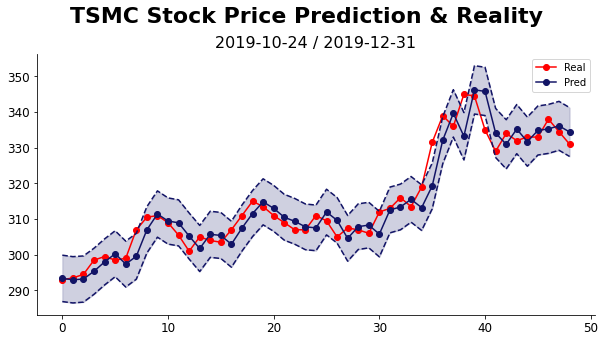

In [ ]:
fig = plt.figure(figsize = (10,5))
ax = fig.add_subplot()

fig.suptitle('TSMC Stock Price Prediction & Reality', fontsize=22, fontweight='bold')
ax.set_title('2019-10-24 / 2019-12-31', fontsize=16,)# fontweight='bold')
fig.subplots_adjust(top=0.85)

ax.tick_params(labelsize=12)
ax.plot(df.real, color='red', label='Real', marker='o',
         markerfacecolor='red',markersize=6)
ax.plot(df.pred, color='#121466', label='Pred', marker='o',
         markerfacecolor='#121466',markersize=6)
ax.legend()
ax.plot(df.lb, color='#121466', ls="--", alpha = 1)
ax.plot(df.ub, color='#121466', ls="--", alpha = 1)
ax.fill_between(df.index, 
                df.lb,
                df.ub,
                color = '#121466',
                alpha=.2,)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig('TSMC_prediction.png',dpi=300)